# Feature Engineering

Convert data into more ML friendly formats.  Reversible so the model output later can be reverted back to TLE style format.

This conversion needs to be performed on all datasets.

Features:

| Column        | Desc  | Effect on SGP4 |
| :------------- | :------| :----|
| `NORAD_CAT_ID` | Satellite identifier, not used in training, no action needed |
| `OBJECT_TYPE` | Satellite meta data, not used in training, no action needed (only in `full` version) |
| `TLE_LINE1` | Actual TLE line 1, not used in training, no action needed (only in `full` version) |
| `TLE_LINE2` | Actual TLE line 2, not used in training, no action needed (only in `full` version) |
| `MEAN_MOTION_DOT` | Some sort of scaling may be needed | NOT used in SGP4 propagation |
| `MEAN_MOTION_DDOT` | Some sort of scaling may be needed | NOT used in SGP4 propagation |
| `BSTAR` | Some sort of scaling may be needed | Affects `v` component based on `r` (assuming higher bstar = higher drag = more decay) |
| `INCLINATION` | Convert cyclic 0 .. 180 | Defines path of possible `r` values (0 = equator, 90 = polar orbit) |
| `RA_OF_ASC_NODE` | Convert cyclic 0 .. 360 | Defines path of possible `r` values (kind of like rotating the orbit viewed from the poles?) |
| `ECCENTRICITY` | Some scaling needed, 0 .. 0.25 | Defines path of possible `r` values (0 = circular orbit) |
| `ARG_OF_PERICENTER` | Convert cyclic 0 .. 360 | Defines path of possible `r` values (0 means closest when crossing north-south reference plane) |
| `MEAN_ANOMALY` | Convert cyclic 0 .. 360, this loops multiple times per day and most cycles are unobserved in the data | Defines which `r` position is used |
| `MEAN_MOTION` | > 11.25 | Defines path of possible `r` values (smaller = longer orbit) |
| `REV_AT_EPOCH` | 0-99999, but sometimes inconcsistency in data where there is an offset to this from different ground stations (a guess) | NOT used in SGP4 propagation |
| `EPOCH` | Time, while no scaling is needed, we will need to use this for constructing `X` and `y` | Time and time offset used for propagation |
| `GP_ID` | Unique identifier for the TLE entry, not used in training, no action needed |

While `MEAN_ANOMALY` is represeted in degrees, because a lot of cycles are left out due to how sparse the data is, a combination of `REV_AT_EPOCH` + `MEAN_ANOMALY` may be a better representation of the features rather than using sin/cos representation.  Other conversion can be done without grouping, but due to `REV_AT_EPOCH` rolling over at 100k and inconsistency between ground stations, we might need to handle it per satellite.



Datasets:

```
2_min/train.pkl
0_min/test.pkl
0_min/secret_test.pkl
```

Converting `min` versions only for now to save some memory and disk space.  Can be replaced with `full` if needed.

In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

import sys

sys.path.append('../models/model_0')
from clean_data import __jday_convert

,YEAR,MONTH,DAY,SUNSPOTS
64837,1995,7,9,32.000000
70837,2011,12,12,118.142857
74095,2020,11,12,34.571429


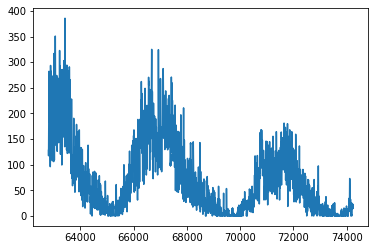

In [2]:
sunspots = pd.read_csv("./sunspots.csv", delimiter=";", names=["YEAR","MONTH","DAY","yf","daily_ss","ss_std","num_obsr","flag"])
sunspots = sunspots[sunspots.yf.between(1989.95,2021.5)]
sunspots['SUNSPOTS'] = sunspots['daily_ss'].rolling(7,1).mean()
sunspots = sunspots[['YEAR','MONTH','DAY','SUNSPOTS']]
plt.plot(sunspots['SUNSPOTS'])
sunspots.sample(3)

In [3]:
def cyclic_repr(s,v):
    cos = np.cos(np.deg2rad(s * (360/v)))
    sin = np.sin(np.deg2rad(s * (360/v)))
    return cos,sin

def convert_feature_values(df):
    name = df.name
    df = df.set_index("EPOCH").sort_index()
    # convert ARG_OF_PERICENTER, RA_OF_ASC_NODE, and MEAN_ANOMALY to non-cyclic version
    df["ARG_OF_PERICENTER_ADJUSTED"] = np.cumsum(np.around(df.ARG_OF_PERICENTER.diff().fillna(0) / -360))*360 + df.ARG_OF_PERICENTER
    df["RA_OF_ASC_NODE_ADJUSTED"] = np.cumsum(np.around(df.RA_OF_ASC_NODE.diff().fillna(0) / -360))*360 + df.RA_OF_ASC_NODE
    
    # this is because for REV_AT_EPOCH = 100,000, it's recorded as 10,000 instead of 0
    # this doesn't handle the case for multiple ground stations reporting though, if the previous is different....
    # would it be better to just remove this as an outlier just to be safe?
    # 90k +- 20 max offset based on MEAN_MOTION maximum from earlier steps
    df.loc[(df.REV_AT_EPOCH==10000) & df.REV_AT_EPOCH.diff().between(-90020,-89980),'REV_AT_EPOCH'] = 0

    # combine REV_AT_EPOCH and MEAN_ANOMALY for a non-cyclic representation
    adjusted_rev = df.REV_AT_EPOCH + np.cumsum(np.around(df.REV_AT_EPOCH.diff().fillna(0) / -100000)) * 100000
    df["REV_MEAN_ANOMALY_COMBINED"] = adjusted_rev * 360 + df.MEAN_ANOMALY
    
    # this is to handle the REV_AT_EPOCH problem inconsistency problem
    # otherwise the REV_MEAN_ANOMALY_COMBINED difference may be incorrect
    # bfill because we may start at non-zero due to previous data removal bit
    a = np.round((adjusted_rev.diff().fillna(method='bfill')/2000))
    df["SUBGROUP"] = np.cumsum(a).astype(int)
    
    cos, sin = cyclic_repr(df.index.dayofyear, 366)
    df["DAY_OF_YEAR_COS"] = cos
    df["DAY_OF_YEAR_SIN"] = sin
    
    df["YEAR"] = df.index.year
    df["MONTH"] = df.index.month
    df["DAY"] = df.index.day
    
    df = df.reset_index().merge(sunspots, on=["YEAR", "MONTH", "DAY"]).dropna() # drop if no sunspot data :(
    
    return df

# Leaving here for reference only, not actually used anymore
def revert_feature_values(df):
    df['REV_AT_EPOCH'] = ((df.REV_MEAN_ANOMALY_COMBINED // 360) % 100000).astype(int)
    df['MEAN_ANOMALY'] = df.REV_MEAN_ANOMALY_COMBINED % 360
    df['RA_OF_ASC_NODE'] = df.RA_OF_ASC_NODE_ADJUSTED % 360
    df['ARG_OF_PERICENTER'] = df.ARG_OF_PERICENTER_ADJUSTED % 360
    return df

In [4]:
#TEST

train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/train.pkl")
train_ids = np.random.choice(train_df.NORAD_CAT_ID.unique(), 20)
train_df = train_df[train_df.NORAD_CAT_ID.isin(train_ids)]

In [5]:
# input is 1 groupby of satellite
def generate_X_y(df):
    idx = df.name

    df = df.drop_duplicates(subset=['EPOCH']).sort_values("EPOCH")
    dfs = []
    for i in range(1,11):
        dfi = pd.concat([df,df.shift(-i).add_suffix("_b")], axis=1).dropna()
        dfs.append(dfi)
    ddf = pd.concat(dfs)

    # Reference variables only, DO NOT USE TO TRAIN
    df = ddf[['NORAD_CAT_ID','GP_ID','GP_ID_b','EPOCH','EPOCH_b']]
    df.columns = ['__NORAD_CAT_ID','__GP_ID_1','__GP_ID_2','__EPOCH_1','__EPOCH_2']
    df['__GP_ID_2'] = df['__GP_ID_2'].astype(int)
    
    # X
    x_cols = ['MEAN_MOTION_DOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER',
              'MEAN_ANOMALY', 'MEAN_MOTION', 'REV_AT_EPOCH',
              'DAY_OF_YEAR_COS', 'DAY_OF_YEAR_SIN', 'YEAR', 'MONTH', 'DAY',
              'SUNSPOTS',]
#     df[['X_EPOCH_JD', 'X_EPOCH_FR']] = ddf.EPOCH.apply(__jday_convert).to_list() # turns out this will overfit
    df[['X_'+x for x in x_cols]] = ddf[x_cols]
    df['X_delta_EPOCH'] = (ddf.EPOCH_b - ddf.EPOCH).astype(int) / 86400000000000 # in days
    # y
    df['y_delta_INCLINATION'] = ddf.INCLINATION_b - ddf.INCLINATION
    df['y_delta_ECCENTRICITY'] = ddf.ECCENTRICITY_b - ddf.ECCENTRICITY
    df['y_delta_MEAN_MOTION'] = ddf.MEAN_MOTION_b - ddf.MEAN_MOTION
    df['y_delta_ARG_OF_PERICENTER'] = ddf.ARG_OF_PERICENTER_ADJUSTED_b - ddf.ARG_OF_PERICENTER_ADJUSTED
    df['y_delta_RA_OF_ASC_NODE'] = ddf.RA_OF_ASC_NODE_ADJUSTED_b - ddf.RA_OF_ASC_NODE_ADJUSTED
    df['y_delta_REV_MEAN_ANOMALY_COMBINED'] = ddf.REV_MEAN_ANOMALY_COMBINED_b - ddf.REV_MEAN_ANOMALY_COMBINED
    
    # not sure if this day limiting thing makes sense....
    df = df[(df['X_delta_EPOCH'] < 5) & (df['X_delta_EPOCH'] > 0.25)]
    return df

In [9]:
%%time

# Generate actual data

input_files = [
    (2, "train"),
    (1, "test"),
    (1, "secret_test")
]

for n,f in input_files:
    print(f"Preparing data for: {f}")
    df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../{n}_min/{f}.pkl")
    converted_df = df.groupby(by="NORAD_CAT_ID", as_index=False).progress_apply(convert_feature_values)
    processed_df = converted_df.groupby(["NORAD_CAT_ID","SUBGROUP"], as_index=False).progress_apply(generate_X_y).reset_index(drop=True)
    processed_df.to_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/{f}.pkl")

Preparing data for: train


  0%|          | 0/12298 [00:00<?, ?it/s]

  0%|          | 0/40045 [00:00<?, ?it/s]

Preparing data for: test


  0%|          | 0/3150 [00:00<?, ?it/s]

  0%|          | 0/8764 [00:00<?, ?it/s]

Preparing data for: secret_test


  0%|          | 0/3147 [00:00<?, ?it/s]

  0%|          | 0/9441 [00:00<?, ?it/s]

CPU times: user 1h 15min 1s, sys: 3min 51s, total: 1h 18min 52s
Wall time: 1h 42min 48s


In [8]:
%%time

# generate smaller set from training set to test

train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/train.pkl")
converted_df = train_df.groupby(by="NORAD_CAT_ID", as_index=False).progress_apply(convert_feature_values)

# narrow down using certain inclination range only
sample_df = converted_df[converted_df.INCLINATION.between(65,67)]

# narrow down further with random norad IDs
train_ids = np.random.choice(sample_df.NORAD_CAT_ID.unique(), 90)
test_ids = np.random.choice(list(set(sample_df.NORAD_CAT_ID.unique())-set(train_ids)),10)

sample_train_df = sample_df[sample_df.NORAD_CAT_ID.isin(train_ids)]
sample_test_df = sample_df[sample_df.NORAD_CAT_ID.isin(test_ids)]

processed_sample_train_df = sample_train_df.groupby(["NORAD_CAT_ID","SUBGROUP"], as_index=False).progress_apply(generate_X_y).reset_index(drop=True)
processed_sample_test_df = sample_test_df.groupby(["NORAD_CAT_ID","SUBGROUP"], as_index=False).progress_apply(generate_X_y).reset_index(drop=True)

# save samples
processed_sample_train_df.to_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_train.pkl")
processed_sample_test_df.to_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_test.pkl")

print(len(processed_sample_train_df))
print(len(processed_sample_test_df))

  0%|          | 0/12298 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

2819944
194306
CPU times: user 4min 15s, sys: 16.1 s, total: 4min 31s
Wall time: 4min 33s
